In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
import nibabel as nib

## Training data

In [4]:

datat1_path = 'TFM/TFM_data/Training_t1/'
datat1ce_path = 'TFM/TFM_data/Training_t1ce/'
datat2_path = 'TFM/TFM_data/Training_t2/'
dataflair_path = 'TFM/TFM_data/Training_flair/'
seg_path = 'TFM/TFM_data/Training_seg/' # Carpeta con los 162 archivos _seg.nii.gz

imgst1_names = []
imgst1ce_names = []
imgst2_names = []
imgsflair_names = []
    
for base, dirs, files in os.walk(datat1_path):
    imgst1_names = files
imgst1_names.sort()
    
for base, dirs, files in os.walk(datat1ce_path):
    imgst1ce_names = files
imgst1ce_names.sort()
    
for base, dirs, files in os.walk(datat2_path):
    imgst2_names = files
imgst2_names.sort()
    
for base, dirs, files in os.walk(dataflair_path):
    imgsflair_names = files
imgsflair_names.sort()


In [5]:
imgst1_names[3][:-9] # toma hasta los ultimos 11 elementos que es donde aparece el tipo de archivo

'Brats18_2013_13_1_'

In [6]:
# modificamos el nombre para que tengan la ruta para poder cargarlos con nib.load 
tags_names = imgst1_names.copy()

for i in range(len(imgst1_names)):
    imgst1_names[i] = datat1_path + imgst1_names[i]
    imgst1ce_names[i] = datat1ce_path + imgst1ce_names[i]
    imgst2_names[i] = datat2_path + imgst2_names[i]
    imgsflair_names[i] = dataflair_path + imgsflair_names[i]
    tags_names[i] = seg_path + tags_names[i][:-9] + 'seg.nii.gz'


In [7]:
# creamos las listas vacías donde se almacenarán las imágenes
data_t1 = []
imagenes_t1 = []

data_t1ce = []
imagenes_t1ce = []

data_t2 = []
imagenes_t2 = []

data_flair = []
imagenes_flair = []

for i in range(len(imgst1_names)):
    data_t1.append(nib.load(imgst1_names[i]))
    imagenes_t1.append(data_t1[i].get_data())
    
    data_t1ce.append(nib.load(imgst1ce_names[i]))
    imagenes_t1ce.append(data_t1ce[i].get_data())
    
    data_t2.append(nib.load(imgst2_names[i]))
    imagenes_t2.append(data_t2[i].get_data())
    
    data_flair.append(nib.load(imgsflair_names[i]))
    imagenes_flair.append(data_flair[i].get_data())
    

In [8]:
# hacemos lo mismo pero para las etiquetas
data_seg = []
etiquetas = []

for i in range(len(tags_names)):
    data_seg.append(nib.load(tags_names[i]))
    etiquetas.append(data_seg[i].get_data())

### Explorando los datos

In [9]:
len(imagenes_t2) # número de pacientes

162

In [10]:
imagenes_t2[1].shape # dimensión de datos por paciente (cada cerebro dividido en 240 rebanadas)

(240, 240, 155)

In [11]:
print("Dimension de una imagen axial de RM: ",imagenes_t2[1][:,:,4].shape)

Dimension de una imagen axial de RM:  (240, 240)


## Reducir el dataset

Dado que si entrenamos la red con la totalidad de las imágenes se demoraría mucho, los dos procedimientos seguidos para acortar el dataset son los siguientes:

- **Eliminar imágenes del dataset de TCIA.** Esto se debe a que la calidad de las imágenes es bastante baja en comparación con la de otras imágenes de los otros datsets. Este conjunto de datos lo componen los últimos 54 pacientes, por lo que habrá un total de 12960 imágenes procedentes de este dataset.

- **Eliminar las imágenes del principio y final del escáner de RM del paciente.** Estas primeras y últimas imágenes serán completamente negras, por lo que no aportarán ningún tipo de información a nuestro entrenamiento, y lo único que harían sería demorarlo.

In [12]:
imagenes_t1 = np.asarray(imagenes_t1)
imagenes_t1ce = np.asarray(imagenes_t1ce)
imagenes_t2 = np.asarray(imagenes_t2)
imagenes_flair = np.asarray(imagenes_flair)
etiquetas = np.asarray(etiquetas)

In [13]:
# Nos quedamos con todas los pacientes, menos los 56 últimas. 
# Es decir, tomamos los 108 primeros pacientes de nuestro conjunto

imagenes_t1 = imagenes_t1[0:108]
imagenes_t1ce = imagenes_t1ce[0:108]
imagenes_t2 = imagenes_t2[0:108]
imagenes_flair = imagenes_flair[0:108]
etiquetas = etiquetas[0:108]

## División Train y Test 

In [14]:
train_t1 = imagenes_t1[:81]
train_t1ce = imagenes_t1ce[:81]
train_t2 = imagenes_t2[:81]
train_flair = imagenes_flair[:81]
train_seg = etiquetas[:81]

test_t1 = imagenes_t1[81:]
test_t1ce = imagenes_t1ce[81:]
test_t2 = imagenes_t2[81:]
test_flair = imagenes_flair[81:]
test_seg = etiquetas[81:]

In [15]:
print('Train:', train_t1ce.shape)
print('Test:', test_t1ce.shape)

Train: (81, 240, 240, 155)
Test: (27, 240, 240, 155)


**Para hacer el conjunto global con todas las secuencias, tomaremos menos pacientes de cada tipo**

In [16]:
train_imgs = np.concatenate((train_t1[:40], train_t1ce[:40], train_t2[:40], train_flair[:40]))
test_imgs = np.concatenate((test_t1[:15], test_t1ce[:15], test_t2[:15], test_flair[:15]))

In [17]:
train_imgs_seg = np.repeat(train_seg[:40],4,axis=0)
test_imgs_seg = np.repeat(test_seg[:15],4,axis=0)

In [18]:
print('Train:', train_imgs.shape)
print('Test:', test_imgs.shape)

Train: (160, 240, 240, 155)
Test: (60, 240, 240, 155)


## Eliminamos la agrupación de imágenes y etiquetas por paciente

El siguiente paso se realiza en tres pasos por separado, ya que al hacerlo en un solo paso tardaba mucho en ejecutar.
Los tres arrays resultantes se concatenarán al final en uno solo.

In [19]:
# invertimos el orden de los ejes para poder eliminar la agrupación por pacientes
train_t1 = np.transpose(train_t1, (0,3,2,1))
test_t1 = np.transpose(test_t1, (0,3,2,1))

train_t1ce = np.transpose(train_t1ce, (0,3,2,1))
test_t1ce = np.transpose(test_t1ce, (0,3,2,1))

train_t2 = np.transpose(train_t2, (0,3,2,1))
test_t2 = np.transpose(test_t2, (0,3,2,1))

train_flair = np.transpose(train_flair, (0,3,2,1))
test_flair = np.transpose(test_flair, (0,3,2,1))

train_seg = np.transpose(train_seg, (0,3,2,1))
test_seg = np.transpose(test_seg, (0,3,2,1))


In [20]:
train_imgs = np.transpose(train_imgs, (0,3,2,1))
test_imgs = np.transpose(test_imgs, (0,3,2,1))

train_imgs_seg = np.transpose(train_imgs_seg, (0,3,2,1))
test_imgs_seg = np.transpose(test_imgs_seg, (0,3,2,1))

print('Train global:',train_imgs.shape)
print('Test global:',test_imgs.shape)
print('Train global_seg:',train_imgs_seg.shape)
print('Test global_seg:',test_imgs_seg.shape)

Train global: (160, 155, 240, 240)
Test global: (60, 155, 240, 240)
Train global_seg: (160, 155, 240, 240)
Test global_seg: (60, 155, 240, 240)


In [21]:
# agrupamos los dos primeros índices
train_t1 = np.reshape(a=train_t1, newshape=(12555,240,240))
train_t1ce = np.reshape(a=train_t1ce, newshape=(12555,240,240))
train_t2 = np.reshape(a=train_t2, newshape=(12555,240,240))
train_flair = np.reshape(a=train_flair, newshape=(12555,240,240))
train_seg = np.reshape(a=train_seg, newshape=(12555,240,240))

In [22]:
test_t1 = np.reshape(a=test_t1, newshape=(4185,240,240))
test_t1ce = np.reshape(a=test_t1ce, newshape=(4185,240,240))
test_t2 = np.reshape(a=test_t2, newshape=(4185,240,240))
test_flair = np.reshape(a=test_flair, newshape=(4185,240,240))
test_seg = np.reshape(a=test_seg, newshape=(4185,240,240))

In [23]:
train_imgs = np.reshape(a=train_imgs, newshape=(24800,240,240))
train_imgs_seg = np.reshape(a=train_imgs_seg, newshape=(24800,240,240))
test_imgs = np.reshape(a=test_imgs, newshape=(9300,240,240))
test_imgs_seg = np.reshape(a=test_imgs_seg, newshape=(9300,240,240))

In [24]:
np.save('./TFM/datasets/train_imgs.npy',train_imgs)
np.save('./TFM/datasets/train_imgs_seg.npy',train_imgs_seg)
np.save('./TFM/datasets/test_imgs.npy',test_imgs)
np.save('./TFM/datasets/test_imgs_seg.npy',test_imgs_seg)

In [25]:
np.save('./TFM/datasets/train_t1.npy',train_t1)
np.save('./TFM/datasets/train_t1ce.npy',train_t1ce)
np.save('./TFM/datasets/train_t2.npy',train_t2)
np.save('./TFM/datasets/train_flair.npy',train_flair)
np.save('./TFM/datasets/train_seg.npy',train_seg)

In [26]:
np.save('./TFM/datasets/test_t1.npy',test_t1)
np.save('./TFM/datasets/test_t1ce.npy',test_t1ce)
np.save('./TFM/datasets/test_t2.npy',test_t2)
np.save('./TFM/datasets/test_flair.npy',test_flair)
np.save('./TFM/datasets/test_seg.npy',test_seg)

**Si se empieza el notebook a partir de este punto, cargamos los datos de train/test**

In [ ]:
# train_t1 = np.load('./TFM/datasets/train_t1.npy')
# train_t1ce = np.load('./TFM/datasets/train_t1ce.npy')
# # train_t2 = np.load('./TFM/datasets/train_t2.npy')
# # train_flair = np.load('./TFM/datasets/train_flair.npy')
# train_seg = np.load('./TFM/datasets/train_seg.npy')

In [ ]:
# test_t1 = np.load('./TFM/datasets/test_t1.npy')
# test_t1ce = np.load('./TFM/datasets/test_t1ce.npy')
# # test_t2 = np.load('./TFM/datasets/test_t2.npy')
# # test_flair = np.load('./TFM/datasets/test_flair.npy')
# test_seg = np.load('./TFM/datasets/test_seg.npy')

In [ ]:
# train_imgs = np.load('./TFM/datasets/train_imgs.npy')
# train_imgs_seg = np.load('./TFM/datasets/train_imgs_seg.npy')
# test_imgs = np.load('./TFM/datasets/test_imgs.npy')
# test_imgs_seg = np.load('./TFM/datasets/test_imgs_seg.npy')

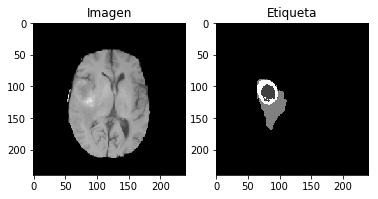

In [27]:
plt.subplot(1,2, 1)
plt.imshow(train_imgs[76], cmap='gray')
plt.title('Imagen')

plt.subplot(1,2, 2)
plt.imshow(train_imgs_seg[76], cmap='gray')
plt.title('Etiqueta')

plt.show()

---

## Normalización imágenes

Crearemos una función que normalice las imágenes. Para ello, buscará el valor máximo de cada imagen, y la dividirá toda ella por este valor. De este modo, el mapa de píxeles que compondrá la imagen tendrá un rango de 0 a 1.

Asímismo, esta función no hará ninguna acción sobre las imágenes que sean totalmente negras, es decir, las que se componen exclusivamente por 0s. Estas las dejará intactas, puesto que si las dividiera por su máximo (en este caso, 0), serían matrices compuestas por nan. De este modo, las imágenes seguirán siendo mapas de 0s.

In [28]:
def normalizar(imagenes):
    """Normaliza las imágenes contenidas en el array que se pasa como parámetro,
    dividiéndo el valor de todos sus píxeles por el máximo.
    No hace nada si la imagen es totalmente negra, i.e. suma = 0.
    De este modo el mapa de píxeles tendrá valores entre 0 y 1"""
    imgs = imagenes.copy()
    
    imgs_norm = [imgs[i]/np.max(imgs[i]) if np.sum(imgs[i])!=0 else imgs[i] for i in range(len(imgs)) ]  
    imgs_norm = np.asarray(imgs_norm)
        
    return imgs_norm

In [29]:
# Normalizamos ahora las imágenes
train_t1_norm = normalizar(train_t1)
train_t1ce_norm = normalizar(train_t1ce)
train_imgs_norm = normalizar(train_imgs)

test_t1_norm = normalizar(test_t1)
test_t1ce_norm = normalizar(test_t1ce)
test_imgs_norm = normalizar(test_imgs)

In [30]:
print(train_imgs_norm.shape)

(24800, 240, 240)


In [31]:
# Comprobamos que efectivamente se han normalizado las imágenes, 
# tomando un elemento cualquiera de nuestro array inicial, y el mismo
# del nuevo array, para ver si los píxeles tienen valores entre 0 y 1

print('Antes de normalizar:')
print(train_t1[65][120])
print('')
print('Después de normalizar:')
print(train_t1_norm[65][120])

# Comprobamos también que las imágenes inciales, compuestas solo por 0s, siguen igual y no aparecen como nan
print('')
print('Imagen negra después de normalizar:')
print(train_t1_norm[1][120])

Antes de normalizar:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 167  79 116 371 427 452 447 430 412 427 438 437 431 447 448 425 427
 423 400 382 383 392 405 420 439 469 498 508 510 520 547 567 574 575 590
 603 603 601 595 604 625 645 615 553 523 510 493 468 462 465 451 431 431
 425 421 425 424 420 410 408 415 416 414 429 445 442 425 420 415 423 390
 271 300 383 420 415 404 415 417 430 429 429 438 443 437 436 446 454 455
 460 465 461 466 468 444 424 410 439 454 443 437 432 427 416 402 384 351
 281 246 269 307 334 378 408 413 412 411 416 421 411 397 389 388 387 378
 341 279  59   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]

Des

## Eliminar imágenes negras

Las primeras y últimas imágenes de cada escáner de RM son totalmente negras, por lo que no aportan ninguna información útil a nuestra red. Es por esto que las eliminaremos para reducir las dimensiones de nuestro dataset y que el entrenamiento de la red neuronal no se demore demasiado.

También es conveniente eliminar aquellas imágenes que son prácticamente negras en su totalidad y tampoco aportan mucha info para el entrenamiento. Estas imágenes tienen píxeles distintos de 0, pero estableceremos un umbral (suma de los píxeles de la imagen) mínimo a partir del cual consideraremos que la imagen aporta información relevante a nuestra red.


In [32]:
def eliminar_no_relevantes(imagenes, etiquetas, umbral): 
    """Del array de imágenes de rebanadas de cerebro que se pasa, guarda el índice de aquellas 
    cuya suma sea inferior a un umbral, ya que serán imágenes casi completamente negras que no aporten mucha información. 
    Se obtienen los índices de las imágenes que nos interesan y se hace slicing del array original con estos índices.
    Hace lo mismo con las etiquetas correspondientes."""
    
    # posiciones de las imágenes casi enteras negras
    indices_negras = [i for i,img in enumerate(imagenes) if np.sum(imagenes[i]) < umbral]
    indices_negras = np.asarray(indices_negras) # convertimos la lista a array
    
    indices_todas = np.arange(len(imagenes))
    
    # posiciones de las imágenes con las que nos queremos quedar
    ind_buenas = np.setdiff1d(indices_todas, indices_negras)
    
    imagenes2 = imagenes[ind_buenas]
    etiquetas2 = etiquetas[ind_buenas]
    
    return imagenes2, etiquetas2

Vamos a mostrar algunas imágenes con sus etiquetas correspondientes. Además, buscaremos una imagen que consideremos que no aporta la suficiente información relevante para nuestra red y obtendremos la suma de sus píxeles. 

Este valor nos servirá como umbral de referencia para eliminar otras imágenes poco relevantes.

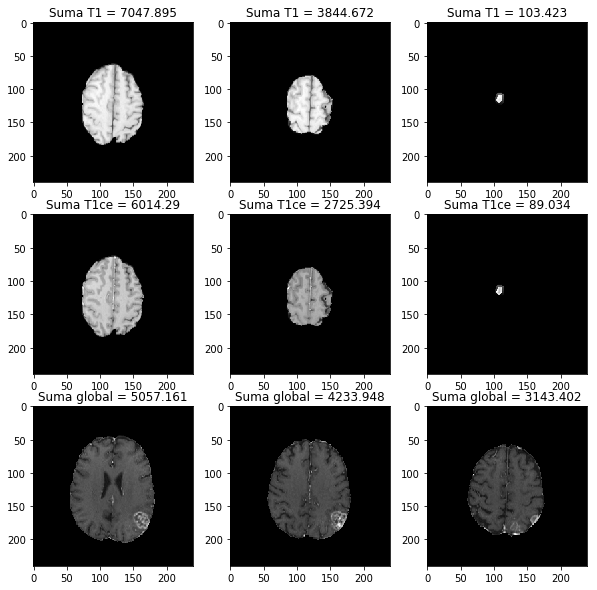

In [33]:
fig = plt.figure(figsize = (10, 10))


plt.subplot(3,3, 1)
plt.imshow(train_t1_norm[120],cmap='gray')
plt.title('Suma T1 = {}'.format(round(np.sum(train_t1_norm[120]),3)))

plt.subplot(3,3, 2)
plt.imshow(train_t1_norm[130],cmap='gray')
plt.title('Suma T1 = {}'.format(round(np.sum(train_t1_norm[130]),3)))

plt.subplot(3,3, 3)
plt.imshow(train_t1_norm[140],cmap='gray')
plt.title('Suma T1 = {}'.format(round(np.sum(train_t1_norm[140]),3)))


plt.subplot(3,3, 4)
plt.imshow(train_t1ce_norm[120],cmap='gray')
plt.title('Suma T1ce = {}'.format(round(np.sum(train_t1ce_norm[120]),3)))

plt.subplot(3,3, 5)
plt.imshow(train_t1ce_norm[130],cmap='gray')
plt.title('Suma T1ce = {}'.format(round(np.sum(train_t1ce_norm[130]),3)))

plt.subplot(3,3, 6)
plt.imshow(train_t1ce_norm[140],cmap='gray')
plt.title('Suma T1ce = {}'.format(round(np.sum(train_t1ce_norm[140]),3)))


plt.subplot(3,3, 7)
plt.imshow(train_imgs_norm[10010],cmap='gray')
plt.title('Suma global = {}'.format(round(np.sum(train_imgs_norm[10010]),3)))

plt.subplot(3,3, 8)
plt.imshow(train_imgs_norm[10020],cmap='gray')
plt.title('Suma global = {}'.format(round(np.sum(train_imgs_norm[10020]),3)))

plt.subplot(3,3, 9)
plt.imshow(train_imgs_norm[10030],cmap='gray')
plt.title('Suma global = {}'.format(round(np.sum(train_imgs_norm[10030]),3)))

plt.show()

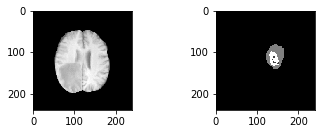

In [36]:
plt.subplot(2,2, 1)
plt.imshow(train_imgs_norm[1030],cmap='gray')

plt.subplot(2,2, 2)
plt.imshow(train_imgs_seg[1030],cmap='gray')


**Este paso es muy importante realizarlo después de haber normalizado las imágenes, para que el umbral sirva por igual a todas.**

Los umbrales escogidos son: 
- T1: 4500
- T1 con contraste: 3500
- conjunto con todas las secuencias: 5000

En el último caso, el umbral escogido es mayor para tomar menos imágenes periféricas por paciente, y quedarse solo con las más centrales.

In [37]:
print('Antes de eliminar las imágenes poco relevantes, nuestro dataset de train tenía:')
print(len(train_t1_norm), 'imágenes T1 y sus correspondiente etiquetas')
print(len(train_t1ce_norm), 'imágenes T1 con contraste y sus correspondiente etiquetas')
print(len(train_imgs_norm), 'imágenes de todas las secuencias y sus correspondiente etiquetas')

Antes de eliminar las imágenes poco relevantes, nuestro dataset de train tenía:
12555 imágenes T1 y sus correspondiente etiquetas
12555 imágenes T1 con contraste y sus correspondiente etiquetas
24800 imágenes de todas las secuencias y sus correspondiente etiquetas


In [38]:
imgs_train_t1,tags_train_t1 = eliminar_no_relevantes(imagenes=train_t1_norm, etiquetas=train_seg, umbral=4500)
imgs_train_t1ce,tags_train_t1ce = eliminar_no_relevantes(imagenes=train_t1ce_norm, etiquetas=train_seg, umbral=3500)
imgs_train_global, tags_train_global = eliminar_no_relevantes(imagenes=train_imgs_norm, etiquetas=train_imgs_seg, umbral=5000)

imgs_test_t1,tags_test_t1 = eliminar_no_relevantes(imagenes=test_t1_norm, etiquetas=test_seg, umbral=4500)
imgs_test_t1ce,tags_test_t1ce = eliminar_no_relevantes(imagenes=test_t1ce_norm, etiquetas=test_seg, umbral=3500)
imgs_test_global, tags_test_global = eliminar_no_relevantes(imagenes=test_imgs_norm, etiquetas=test_imgs_seg, umbral=5000)


In [39]:
print('Después de eliminar las imágenes poco relevantes, nuestro dataset de train tiene:')
print(len(imgs_train_t1), 'imágenes T1 y sus correspondiente etiquetas')
print(len(imgs_train_t1ce), 'imágenes T1 con contraste y sus correspondiente etiquetas')
print(len(imgs_train_global), 'imágenes de todas las secuencias y sus correspondiente etiquetas')

print('')
print('Después de eliminar las imágenes poco relevantes, nuestro dataset de test tiene:')
print(len(imgs_test_t1), 'imágenes T1 y sus correspondiente etiquetas')
print(len(imgs_test_t1ce), 'imágenes T1 con contraste y sus correspondiente etiquetas')
print(len(imgs_test_global), 'imágenes de todas las secuencias y sus correspondiente etiquetas')

Después de eliminar las imágenes poco relevantes, nuestro dataset de train tiene:
7394 imágenes T1 y sus correspondiente etiquetas
4725 imágenes T1 con contraste y sus correspondiente etiquetas
9636 imágenes de todas las secuencias y sus correspondiente etiquetas

Después de eliminar las imágenes poco relevantes, nuestro dataset de test tiene:
2454 imágenes T1 y sus correspondiente etiquetas
1590 imágenes T1 con contraste y sus correspondiente etiquetas
2928 imágenes de todas las secuencias y sus correspondiente etiquetas


##  Binarizar etiquetas

Las etiquetas proporcionada por la organización de BraTS 2018 muestran la segmentación del glioma en el cerebro, diferenciando varias partes.

Para hacerlo más sencillo, se ha decidido convertir estas etiquetas en binarias, de modo que las imágenes segmentadas sean mapas de 0s y 1s. De este modo, simplemente se identificaría la posición del tumor, sin hacer ninguna distinción de sus partes


In [40]:
# FUNCIÓN PARA HACER ETIQUETAS BINARIAS
# En agradecimientos, incluir a Stack overflow, por salvarnos la vida con las dudas de código

def binarizar_etiqueta(etiquetas):
    """Función a la que se le pasa un array de imágenes segmentadas. 
    Hace una copia para que no modificar el array original.
    Convierte el mapa de píxeles en binario, haciendo 1 cualquier píxel con valor distinto de 0."""
    
    tags = etiquetas.copy()
    for tag in tags:
        tag[tag > 0] = 1
    
    return tags

In [41]:
tags_train_t1bin = binarizar_etiqueta(tags_train_t1)
tags_train_t1cebin = binarizar_etiqueta(tags_train_t1ce)
tags_train_globalbin = binarizar_etiqueta(tags_train_global)

tags_test_t1bin = binarizar_etiqueta(tags_test_t1)
tags_test_t1cebin = binarizar_etiqueta(tags_test_t1ce)
tags_test_globalbin = binarizar_etiqueta(tags_test_global)

In [42]:
print('Antes de binarizar:')
print(tags_train_t1[20][120])
print('')
print('Después de binarizar:')
print(tags_train_t1bin[20][120])

Antes de binarizar:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 4 4 4 4 4 1 1 1 1 1 1 1 1 1 4 4 4 4 4 1 4 4 4 4 4 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Después de binarizar:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

Observamos que las etiquetas se han hecho binarias. Vamos a mostrar un ejemplo de imagen de cerebro con sus etiquetas correspondientes, la original y la binaria.

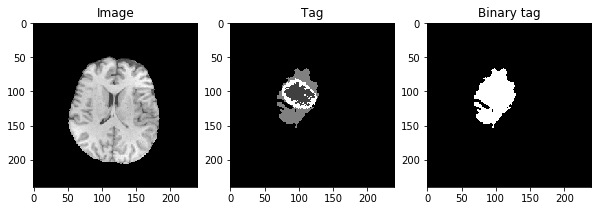

In [43]:
fig = plt.figure(figsize = (10, 9))


plt.subplot(1,3, 1)
plt.imshow(imgs_test_global[300],cmap='gray')
plt.title('Image')

plt.subplot(1,3, 2)
plt.imshow(tags_test_global[300],cmap='gray')
plt.title('Tag')

plt.subplot(1,3, 3)
plt.imshow(tags_test_globalbin[300],cmap='gray')
plt.title('Binary tag')

plt.show()

------

## Separación en train y test

Para entrenar nuestra red, haremos una partición de train/test del 75/25 %.
Tomaremos imágenes aleatoriamente del dataset global, junto con su etiqueta correspondiente.

In [ ]:
# indices_train_t1 = list(range(len(imgs_train_t1)))
# indices_train_t1ce = list(range(len(imgs_train_t1ce)))
# indices_train_global = list(range(len(imgs_train_global)))

# indices_test_t1 = list(range(len(imgs_test_t1)))
# indices_test_t1ce = list(range(len(imgs_test_t1ce)))
# indices_test_global = list(range(len(imgs_test_global)))

In [ ]:
# import random
# random.shuffle(indices_train_t1)
# random.shuffle(indices_train_t1ce)
# random.shuffle(indices_train_global)

# random.shuffle(indices_test_t1)
# random.shuffle(indices_test_t1ce)
# random.shuffle(indices_test_global)

In [ ]:
# imgs_train_t1 = imgs_train_t1[indices_train_t1]
# tags_train_t1 = tags_train_t1[indices_train_t1]
# tags_train_t1bin = tags_train_t1bin[indices_train_t1]

# imgs_train_t1ce = imgs_train_t1ce[indices_train_t1ce]
# tags_train_t1ce = tags_train_t1ce[indices_train_t1ce]
# tags_train_t1cebin = tags_train_t1cebin[indices_train_t1ce]

# imgs_train_global = imgs_train_global[indices_train_global]
# tags_train_global = tags_train_global[indices_train_global]
# tags_train_globalbin = tags_train_globalbin[indices_train_global]


# imgs_test_t1 = imgs_test_t1[indices_test_t1]
# tags_test_t1 = tags_test_t1[indices_test_t1]
# tags_test_t1bin = tags_test_t1bin[indices_test_t1]

# imgs_test_t1ce = imgs_test_t1ce[indices_test_t1ce]
# tags_test_t1ce = tags_test_t1ce[indices_test_t1ce]
# tags_test_t1cebin = tags_test_t1cebin[indices_test_t1ce]

# imgs_test_global = imgs_test_global[indices_test_global]
# tags_test_global = tags_test_global[indices_test_global]
# tags_test_globalbin = tags_test_globalbin[indices_test_global]


Vamos a guardar los arrays obtenidos, de modo que se puedan cargar en futuras ocasiones sin tener que ejecutar todo el código de nuevo.

In [44]:
np.save('./TFM/datasets/train_test/imgs_train_t1.npy',imgs_train_t1)
np.save('./TFM/datasets/train_test/tags_train_t1.npy',tags_train_t1)
np.save('./TFM/datasets/train_test/tags_train_t1bin.npy',tags_train_t1bin)

np.save('./TFM/datasets/train_test/imgs_train_t1ce.npy',imgs_train_t1ce)
np.save('./TFM/datasets/train_test/tags_train_t1ce.npy',tags_train_t1ce)
np.save('./TFM/datasets/train_test/tags_train_t1cebin.npy',tags_train_t1cebin)

np.save('./TFM/datasets/train_test/imgs_train_global.npy',imgs_train_global)
np.save('./TFM/datasets/train_test/tags_train_global.npy',tags_train_global)
np.save('./TFM/datasets/train_test/tags_train_globalbin.npy',tags_train_globalbin)


In [45]:
np.save('./TFM/datasets/train_test/imgs_test_t1.npy',imgs_test_t1)
np.save('./TFM/datasets/train_test/tags_test_t1.npy',tags_test_t1)
np.save('./TFM/datasets/train_test/tags_test_t1bin.npy',tags_test_t1bin)

np.save('./TFM/datasets/train_test/imgs_test_t1ce.npy',imgs_test_t1ce)
np.save('./TFM/datasets/train_test/tags_test_t1ce.npy',tags_test_t1ce)
np.save('./TFM/datasets/train_test/tags_test_t1cebin.npy',tags_test_t1cebin)

np.save('./TFM/datasets/train_test/imgs_test_global.npy',imgs_test_global)
np.save('./TFM/datasets/train_test/tags_test_global.npy',tags_test_global)
np.save('./TFM/datasets/train_test/tags_test_globalbin.npy',tags_test_globalbin)

In [ ]:
fig = plt.figure(figsize = (10, 9))

plt.subplot(1,2, 1)
plt.imshow(imgs_train_t1[18],cmap='gray')

plt.subplot(1,2, 2)
plt.imshow(tags_train_t1bin[18],cmap='gray')

In [ ]:
# np.save('TFM/x_train.npy', imgs_train)
# np.save('TFM/x_test.npy', imgs_test)

In [ ]:
# np.save('TFM/y_train.npy', tags_train)
# np.save('TFM/y_test.npy', tags_test)